In [1]:
import os
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B0  
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')


# Read train data

In [2]:
import pandas as pd
import os

image_dataset_path = "/kaggle/input/ai-vs-human-generated-dataset/"

train_df = pd.read_csv(image_dataset_path + "train.csv")

train_df["file_name"] = image_dataset_path + train_df["file_name"]


train_df.head()


,Unnamed: 0,file_name,label
0,0,/kaggle/input/ai-vs-human-generated-dataset/tr...,1
1,1,/kaggle/input/ai-vs-human-generated-dataset/tr...,0
2,2,/kaggle/input/ai-vs-human-generated-dataset/tr...,1
3,3,/kaggle/input/ai-vs-human-generated-dataset/tr...,0
4,4,/kaggle/input/ai-vs-human-generated-dataset/tr...,1


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79950 entries, 0 to 79949
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  79950 non-null  int64 
 1   file_name   79950 non-null  object
 2   label       79950 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.8+ MB


In [4]:
train_df=train_df.drop('Unnamed: 0',axis=1)

# Check if the training files exist

In [5]:
import os

missing_files = train_df[~train_df["file_name"].apply(os.path.exists)]
print(f"Missing train images: {len(missing_files)}")

Missing train images: 0


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79950 entries, 0 to 79949
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  79950 non-null  object
 1   label      79950 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.2+ MB


# View Ai images and Human images 

In [7]:
import random
from PIL import Image

ai_images = train_df[train_df["label"] == 1]["file_name"].tolist()
human_images = train_df[train_df["label"] == 0]["file_name"].tolist()

# Function to display images
def show_images(image_paths, title, num_images=5):
    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(random.sample(image_paths, num_images)):
        img = Image.open(img_path)  # Open image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(title, fontsize=14)
    plt.show()


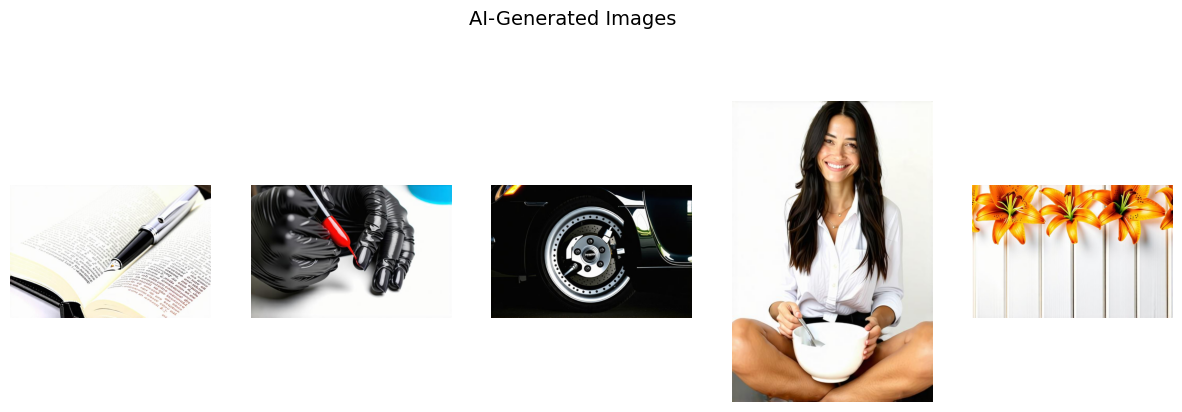

In [8]:
show_images(ai_images, "AI-Generated Images")


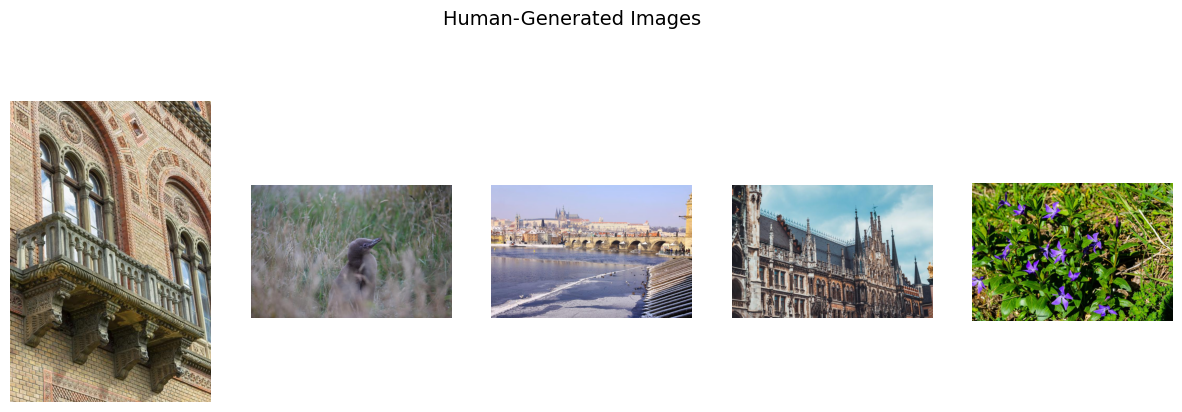

In [9]:
show_images(human_images, "Human-Generated Images")


# Show Similar photos in both 

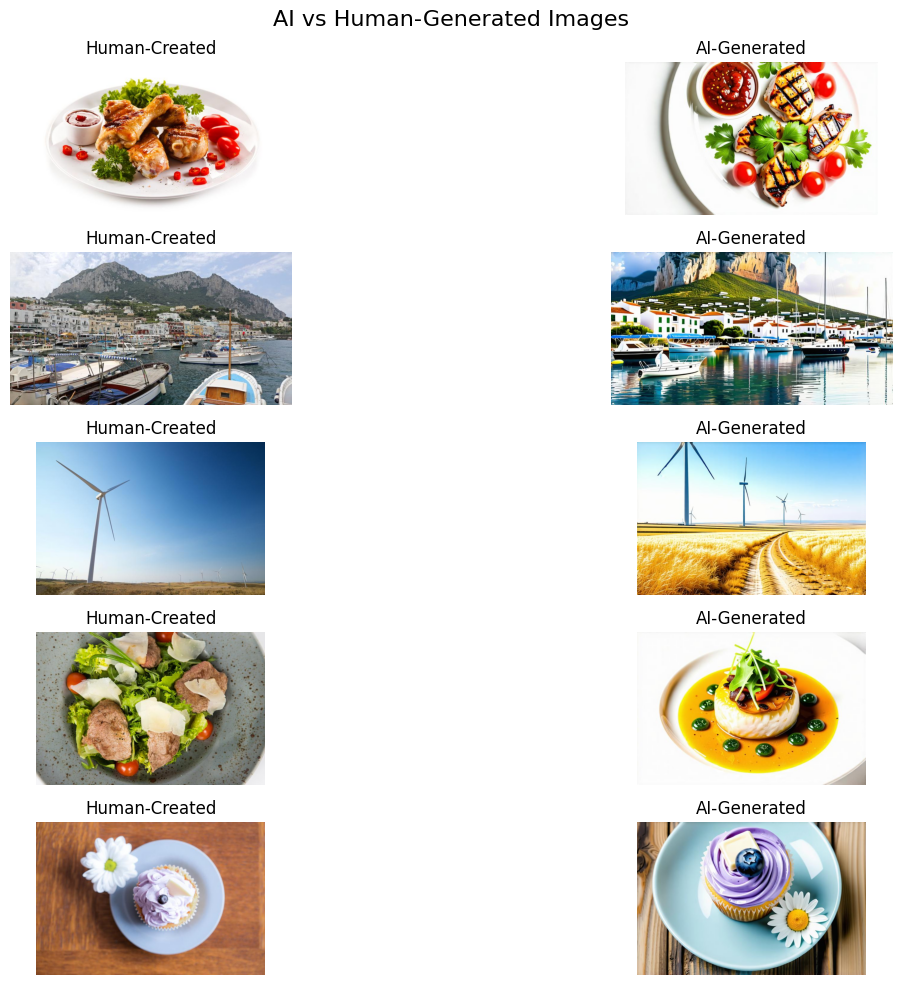

In [10]:
import cv2

def show_ai_vs_human(df, num_images=5):
    ai_images = df[df["label"] == 1]["file_name"].dropna().sample(num_images, random_state=42).values
    human_images = df[df["label"] == 0]["file_name"].dropna().sample(num_images, random_state=42).values

    plt.figure(figsize=(15, num_images * 2))
    
    for i, (ai_img_path, human_img_path) in enumerate(zip(ai_images, human_images)):
        # Read AI Image
        ai_img = cv2.imread(ai_img_path)
        human_img = cv2.imread(human_img_path)

        if ai_img is None or human_img is None:
            print(f"Skipping missing images: {ai_img_path} or {human_img_path}")
            continue  # Skip missing images
        
        ai_img = cv2.cvtColor(ai_img, cv2.COLOR_BGR2RGB)
        human_img = cv2.cvtColor(human_img, cv2.COLOR_BGR2RGB)

        # Show Human Image
        plt.subplot(num_images, 2, i * 2 + 1)
        plt.imshow(human_img)
        plt.axis("off")
        plt.title("Human-Created")

        # Show AI Image
        plt.subplot(num_images, 2, i * 2 + 2)
        plt.imshow(ai_img)
        plt.axis("off")
        plt.title("AI-Generated")

    plt.suptitle("AI vs Human-Generated Images", fontsize=16)
    plt.tight_layout()
    plt.show()

# Display images
show_ai_vs_human(train_df)


# Read test file

In [11]:
import pandas as pd


image_dataset_path = "/kaggle/input/ai-vs-human-generated-dataset/"


test_df = pd.read_csv(image_dataset_path + "test.csv")


test_df["file_path"] = image_dataset_path + test_df["id"] 


test_df.head()


,id,file_path
0,test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg,/kaggle/input/ai-vs-human-generated-dataset/te...
1,test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg,/kaggle/input/ai-vs-human-generated-dataset/te...
2,test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg,/kaggle/input/ai-vs-human-generated-dataset/te...
3,test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg,/kaggle/input/ai-vs-human-generated-dataset/te...
4,test_data_v2/a16495c578b7494683805484ca27cf9f.jpg,/kaggle/input/ai-vs-human-generated-dataset/te...


# check if test files exists

In [12]:
import os

missing_files = test_df[~test_df["file_path"].apply(os.path.exists)]

print(f"Missing test images: {len(missing_files)}")


Missing test images: 0


# Show Test Image Photos

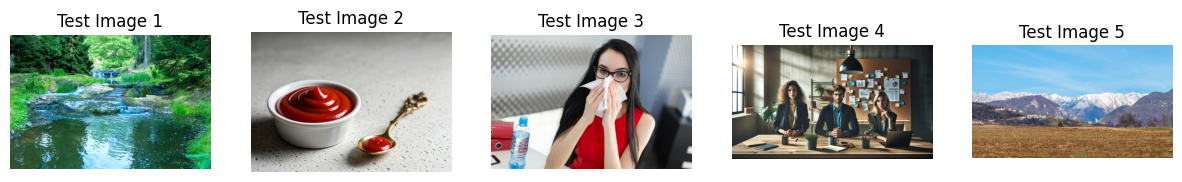

In [13]:
import matplotlib.pyplot as plt
import cv2

def show_test_images(df, num_images=5):
    sample_images = df.sample(num_images, random_state=42)["file_path"].values

    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(sample_images):
        img = cv2.imread(img_path)  
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Test Image {i+1}")
        
    plt.show()

show_test_images(test_df)



In [14]:
print(train_df.head())
print(test_df.head())


                                           file_name  label
0  /kaggle/input/ai-vs-human-generated-dataset/tr...      1
1  /kaggle/input/ai-vs-human-generated-dataset/tr...      0
2  /kaggle/input/ai-vs-human-generated-dataset/tr...      1
3  /kaggle/input/ai-vs-human-generated-dataset/tr...      0
4  /kaggle/input/ai-vs-human-generated-dataset/tr...      1
                                                  id  \
0  test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg   
1  test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg   
2  test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg   
3  test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg   
4  test_data_v2/a16495c578b7494683805484ca27cf9f.jpg   

                                           file_path  
0  /kaggle/input/ai-vs-human-generated-dataset/te...  
1  /kaggle/input/ai-vs-human-generated-dataset/te...  
2  /kaggle/input/ai-vs-human-generated-dataset/te...  
3  /kaggle/input/ai-vs-human-generated-dataset/te...  
4  /kaggle/input/ai-vs-human

# Convert labels to string

In [15]:
train_df["label"] = train_df["label"].astype(str)

# ImageDataGenerator with rescaling and validation split

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)


# train generator 

In [17]:
train_generator = data_generator.flow_from_dataframe(
    train_df,
    x_col="file_name",   
    y_col="label",      
    target_size=(299, 299),  
    batch_size=32,
    class_mode="binary",  
    subset="training" 
)

Found 63960 validated image filenames belonging to 2 classes.


# validation Generator 

In [18]:
valid_generator = data_generator.flow_from_dataframe(
    train_df,
    x_col="file_name",
    y_col="label",
    target_size=(299, 299),
    batch_size=32,
    class_mode="binary",
    subset="validation"
)

Found 15990 validated image filenames belonging to 2 classes.


# InceptionV3 model

In [19]:

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

base_model.trainable = False



87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [20]:
# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Reduce feature maps to a single vector
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)  # Prevent overfitting
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification

# Create final model
model = Model(inputs=base_model.input, outputs=output)

In [21]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast (Cast)               │ (None, 299, 299, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 149, 149, 32)   │            864 │ cast[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 149, 149, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 149, 149, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 147, 147, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 147, 147, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 147, 147, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 147, 147, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 147, 147, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 147, 147, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 73, 73, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 73, 73, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 73, 73, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 71, 71, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 71, 71, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization) 

 Total params: 22,983,457 (87.67 MB)

 Trainable params: 1,180,673 (4.50 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

# Compile model

In [22]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer = 'adam',  
                    loss='binary_crossentropy',
                    metrics=['accuracy'])


# Fitting model

In [23]:
model_history = model.fit(train_generator, epochs=8, validation_data=valid_generator)


Epoch 1/8


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1999/1999 ━━━━━━━━━━━━━━━━━━━━ 798s 385ms/step - accuracy: 0.7800 - loss: 0.4537 - val_accuracy: 0.8498 - val_loss: 0.3329
Epoch 2/8
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 431s 215ms/step - accuracy: 0.8711 - loss: 0.3004 - val_accuracy: 0.8936 - val_loss: 0.2498
Epoch 3/8
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 433s 216ms/step - accuracy: 0.8851 - loss: 0.2695 - val_accuracy: 0.8992 - val_loss: 0.2398
Epoch 4/8
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 429s 214ms/step - accuracy: 0.8944 - loss: 0.2510 - val_accuracy: 0.9041 - val_loss: 0.2304
Epoch 5/8
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 420s 209ms/step - accuracy: 0.9031 - loss: 0.2330 - val_accuracy: 0.9046 - val_loss: 0.2297
Epoch 6/8
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 434s 217ms/step - accuracy: 0.9085 - loss: 0.2208 - val_accuracy: 0.9115 - val_loss: 0.2159
Epoch 7/8
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 433s 216ms/step - accuracy: 0.9133 - loss: 0.2065 - val_accuracy: 0.9106 - val_loss: 0.2197
Epoch 8/8
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 434s 216ms/step - accuracy: 0.9158 - l

# train evaluation 

In [24]:
# Evaluate the model on the training data
train_loss, train_accuracy = model.evaluate(train_generator)

print(f"Accuracy on train data: {train_accuracy:.2%} | Loss: {train_loss:.4f}")

1999/1999 ━━━━━━━━━━━━━━━━━━━━ 349s 175ms/step - accuracy: 0.9361 - loss: 0.1640
Accuracy on train data: 93.41% | Loss: 0.1671


# Test data generator

In [25]:

test_generator = data_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col="file_path",   
    y_col=None,         
    target_size=(299, 299),  
    batch_size=32,
    class_mode=None,     
    shuffle=False        
)

Found 5540 validated image filenames.


# Test Predictions

In [26]:
predictions = model.predict(test_generator)

predicted_labels = (predictions > 0.5).astype(int) 

174/174 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step


# submission file

In [27]:
submission_df = pd.DataFrame({
    'id': test_df['id'],  
    'label': predicted_labels.flatten()  
})

submission_df.to_csv('submission.csv', index=False)

print(submission_df.head())

                                                  id  label
0  test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg      0
1  test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg      0
2  test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg      0
3  test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg      0
4  test_data_v2/a16495c578b7494683805484ca27cf9f.jpg      0


In [28]:
submission_df['label'].value_counts()

label
0    4141
1    1399
Name: count, dtype: int64